In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets            # 取得圖片資料集
import torchvision.transforms as transforms # 圖片 transform
from models.AutoEncoder.VAE import VAE
from utils.draw import showImg

import matplotlib.pyplot as plt
import numpy as np

In [7]:
# 取得資料
temp_data = datasets.MNIST( './dataset', train=True, download=True, transform=transforms.ToTensor() )
temp_dataloader = DataLoader( temp_data, batch_size=10, shuffle=False)

In [19]:
# 訓練資訊 & 超參數
epochs = 10
batch_size = 32
lr = 0.001
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )

train_data = datasets.MNIST( './dataset', train=True, download=True, transform=transforms.ToTensor() )
train_dataloader = DataLoader( train_data, batch_size=batch_size, shuffle=True)

model = VAE( 784, 400, 20).to(device)
optimizer = torch.optim.Adam( model.parameters(), lr=lr )

In [11]:
def vae_loss(gen_img, true_img, mean, sigma):
    pixel_loss = nn.functional.binary_cross_entropy(gen_img, true_img, reduction='sum')
    KL_loss      = - 0.5 * torch.sum(1+ sigma - mean.pow(2) - sigma.exp())
    return pixel_loss + KL_loss

In [20]:
# Train
losses = []
for epoch in range(epochs):
    total_loss = 0
    for true_img, num_label in train_dataloader:      
        
        true_img = true_img.view( -1, 28*28 ).to(device)   # 攤平圖片 

        gen_img, mean, sigma = model( true_img ) 

        loss = vae_loss( gen_img, true_img, mean, sigma)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        losses.append( loss.item() )
        
    total_loss /= len(train_dataloader.dataset) # batch 平均 loss
    
    if(epoch % 2 == 0 ):
        print( f"Epoch: {epoch} / {epochs} \t Loss: {total_loss}")

d:\Tool Files\Python_3_10\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0 / 10 	 Loss: 115.37847875976563
Epoch: 2 / 10 	 Loss: 90.65961946207682
Epoch: 4 / 10 	 Loss: 88.14870819091797
Epoch: 6 / 10 	 Loss: 87.07809970296223
Epoch: 8 / 10 	 Loss: 86.3766537068685


In [21]:
# 印出 loss
# plt.plot( losses)
# plt.show()

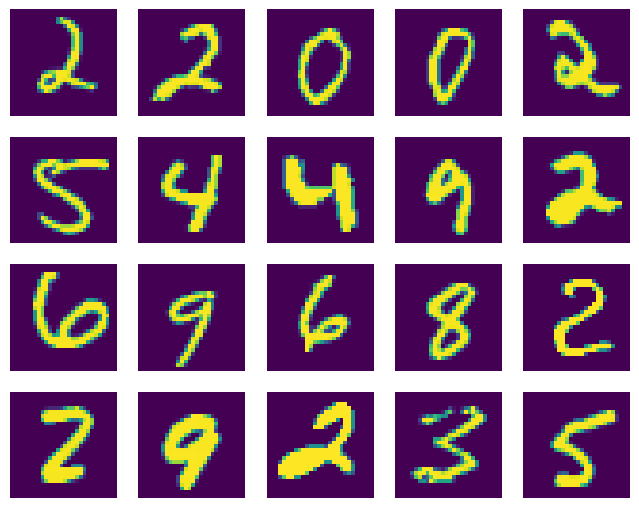

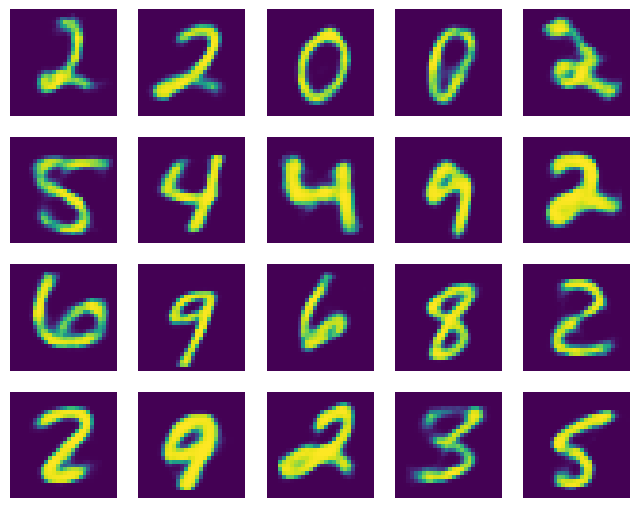

In [22]:
# 進行測試生成
test_data = datasets.MNIST( './dataset', train=False, download=True, transform=transforms.ToTensor() )
test_dataloader = DataLoader( test_data, batch_size=20, shuffle=True)

with torch.no_grad():
    for idx, ( true_img, num_label ) in enumerate( test_dataloader ):
        
        # 攤平圖片
        true_img = true_img.view( -1, 28*28 ).to(device)    
        
        # Unet 生成
        gen_img, _, _ = model( true_img ) 
        
        # 印出圖片
        if( idx == 1 ):
            # 印出原圖片
            showImg( true_img.cpu() )
            # 印出生成圖片
            showImg( gen_img.cpu() )
            plt.show()